In [ ]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d699b95ee89ca99559669c941e1c4a5d548525bb83247485d2ce1038d1a3cb7c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import StringType


# Create a SparkSession
spark = SparkSession.builder.appName("CRWK_weblog").getOrCreate()

In [ ]:
log_data = '/content/drive/MyDrive/web.log'

In [ ]:
log_data_df = spark.read.text(log_data)


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType
from pyspark.sql.functions import regexp_extract

features = ['Host making the request','Timestamp','HTTP method','URL','HTTP Version','HTTP status code','Bytes in the reply','Message']

pattern = r'(\S+) - - \[([^\]]+)\] "(\w+) (\S+) (\S+)" (\d+) (\d+) (.+)'

schema = StructType([
    StructField("Host_making_the_request", StringType(), True),
    StructField("Timestamp", StringType(), True),
    StructField("HTTP_method", StringType(), True),
    StructField("URL", StringType(), True),
    StructField("HTTP_Version", StringType(), True),
    StructField("HTTP_status_code", IntegerType(), True),
    StructField("Bytes_in_the_reply", IntegerType(), True),
    StructField("Message", StringType(), True),
])


# Apply the regex pattern using regexp_extract
log_data_df = log_data_df.select(
    regexp_extract("value", pattern, 1).alias("Host_request Ip address "),
    regexp_extract("value", pattern, 2).alias("Timestamp"),
    regexp_extract("value", pattern, 3).alias("HTTP_method"),
    regexp_extract("value", pattern, 4).alias("URL"),
    regexp_extract("value", pattern, 5).alias("HTTP_version"),
    regexp_extract("value", pattern, 6).alias("HTTP_status_code").cast("int"),
    regexp_extract("value", pattern, 7).alias("Bytes_in_reply").cast("int"),
    regexp_extract("value", pattern, 8).alias("Message")
)
# Show the DataFrame
log_data_df.show(truncate=False)




+------------------------+--------------------+-----------+---------------------------------------+------------+----------------+--------------+--------------------------------------------------------------+
|Host_request Ip address |Timestamp           |HTTP_method|URL                                    |HTTP_version|HTTP_status_code|Bytes_in_reply|Message                                                       |
+------------------------+--------------------+-----------+---------------------------------------+------------+----------------+--------------+--------------------------------------------------------------+
|88.211.105.115          |04/Mar/2022:14:17:48|POST       |/history/missions/                     |HTTP/2.0    |414             |12456         |Caution: System may require attention. Check logs for details.|
|144.6.49.142            |02/Sep/2022:15:16:00|POST       |/security/firewall/                    |HTTPS/1.0   |203             |97126         |Warning: Unusual behavio

In [ ]:
#SQL Queries

log_data_df.createOrReplaceTempView("Weblog")
sqlDF = spark.sql("SELECT * FROM Weblog")
sqlDF.show()

+------------------------+--------------------+-----------+--------------------+------------+----------------+--------------+--------------------+
|Host_request Ip address |           Timestamp|HTTP_method|                 URL|HTTP_version|HTTP_status_code|Bytes_in_reply|             Message|
+------------------------+--------------------+-----------+--------------------+------------+----------------+--------------+--------------------+
|          88.211.105.115|04/Mar/2022:14:17:48|       POST|  /history/missions/|    HTTP/2.0|             414|         12456|Caution: System m...|
|            144.6.49.142|02/Sep/2022:15:16:00|       POST| /security/firewall/|   HTTPS/1.0|             203|         97126|Warning: Unusual ...|
|           231.70.64.145|19/Jul/2022:01:31:31|        PUT|/web-development/...|    HTTP/1.0|             201|         33093|Informational mes...|
|          219.42.234.172|08/Feb/2022:11:34:57|       POST|/networking/techn...|    HTTP/1.0|             415|        

In [ ]:
#Count the number of requests for each HTTP method
query_1 = spark.sql("SELECT HTTP_method, COUNT(*) AS request_count FROM Weblog GROUP BY HTTP_method")

query_1.show()

+-----------+-------------+
|HTTP_method|request_count|
+-----------+-------------+
|       POST|      1000505|
|        PUT|       998452|
|        GET|      1001043|
+-----------+-------------+



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

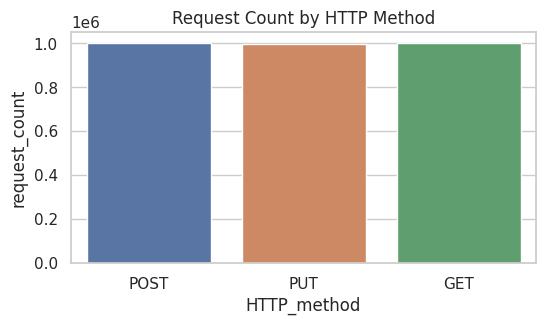

In [ ]:
# Visualization 1: Bar chart for request count by HTTP method
sns.set(style="whitegrid")
plt.figure(figsize=(6, 3))
sns.barplot(x="HTTP_method", y="request_count", data=query_1.toPandas())
plt.title("Request Count by HTTP Method")
plt.show()


In [ ]:
#Calculate the percentage of successful requests (HTTP status code 200) for each URL

query_2 = spark.sql('SELECT URL, (SUM(CASE WHEN HTTP_status_code = 200 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS success_percentage FROM Weblog GROUP BY URL ORDER BY success_percentage DESC LIMIT 10')
query_2.show()


+--------------------+------------------+
|                 URL|success_percentage|
+--------------------+------------------+
| /security/firewall/| 7.582843666306911|
|/software/cyberse...| 7.534906114588348|
|  /shuttle/missions/| 7.523473236497874|
|/networking/techn...|7.4899274778404505|
|/software/aws-cer...| 7.484051036682615|
|/web-development/...| 7.478046648388763|
|     /images/launch/| 7.468979641007108|
|/data-analysis/te...|  7.42094390592722|
|/security/technol...| 7.412968743825819|
|/machine-learning...|  7.38569753810082|
+--------------------+------------------+



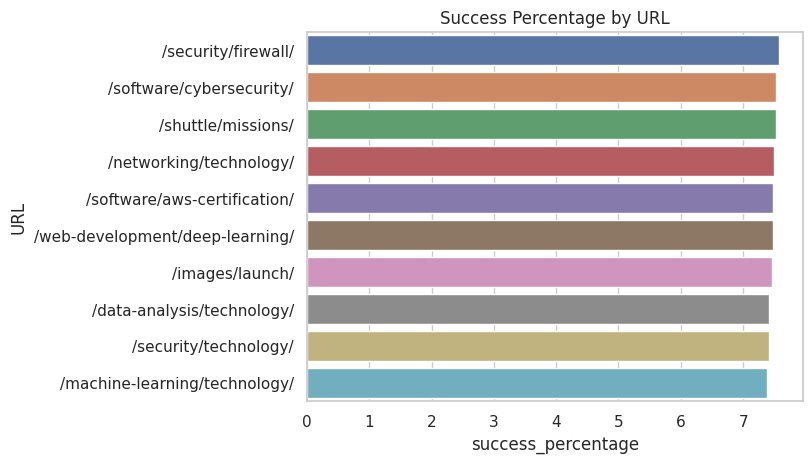

In [ ]:
#Bar chart for success percentage by URL
sns.barplot(x="success_percentage", y="URL", data=query_2.toPandas(), orient="h")
plt.title("Success Percentage by URL")
plt.show()

In [ ]:
#Calculate the total bytes in reply for each HTTP status code using a window function
query_3 = spark.sql(
    'SELECT DISTINCT HTTP_status_code, SUM(Bytes_in_reply) OVER (PARTITION BY HTTP_status_code) AS total_bytes FROM Weblog'
    )
query_3.show()

+----------------+-----------+
|HTTP_status_code|total_bytes|
+----------------+-----------+
|             202|10834551843|
|             205|10817279306|
|             308|10842599413|
|             415|10807895658|
|             416|10822518017|
|             500|10842120097|
|             200|10861065478|
|             203|10797269698|
|             304|10779683877|
|             307|10777026936|
|             404|10856142053|
|             414|10853304596|
|             201|10845605811|
|             204|10760389385|
+----------------+-----------+



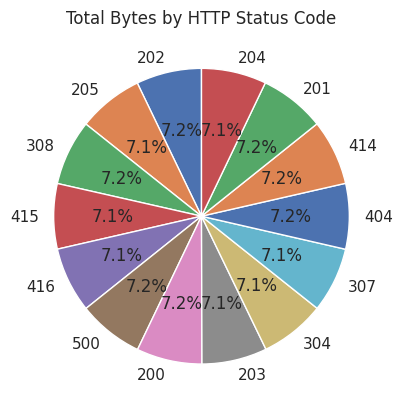

In [ ]:
#Pie chart for total bytes by HTTP status code

from pyspark.sql.window import Window

plt.pie(query_3.select("total_bytes").toPandas()["total_bytes"],
        labels=query_3.select("HTTP_status_code").toPandas()["HTTP_status_code"],
        autopct="%1.1f%%", startangle=90)
plt.title("Total Bytes by HTTP Status Code")
plt.show()

In [ ]:
#Find the top 5 URLs with the highest number of requests and their average bytes

query_4 = spark.sql('SELECT w.URL, COUNT(*) AS request_count, AVG(w.Bytes_in_reply) AS avg_bytes FROM Weblog w JOIN (SELECT URL FROM Weblog GROUP BY URL ORDER BY COUNT(*) DESC LIMIT 5) t ON w.URL = t.URL GROUP BY w.URL')

query_4.show()

+--------------------+-------------+------------------+
|                 URL|request_count|         avg_bytes|
+--------------------+-------------+------------------+
| /history/countdown/|        25338|50391.419014918305|
|/data-analysis/ap...|        25440| 50289.03970125786|
|     /software/data/|        25382| 50368.75884485068|
|/software/technol...|        25327| 50231.99913136179|
|/web-development/...|        25343| 50806.64589827566|
+--------------------+-------------+------------------+



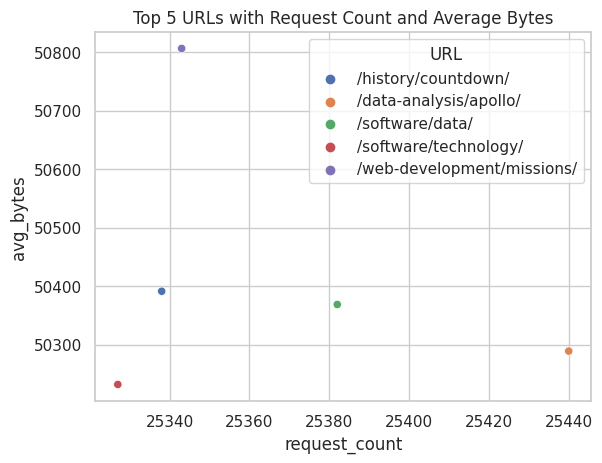

In [ ]:
#Scatter plot for top 5 URLs with request count and average bytes
sns.scatterplot(x="request_count", y="avg_bytes", hue="URL", data=query_4.toPandas())
plt.title("Top 5 URLs with Request Count and Average Bytes")
plt.show()

In [ ]:
#Identify the URLs with more than 10,000 bytes in reply
query_5 = spark.sql('SELECT URL FROM Weblog WHERE Bytes_in_reply > 10000 LIMIT 10')

query_5.show()

+--------------------+
|                 URL|
+--------------------+
|  /history/missions/|
| /security/firewall/|
|/web-development/...|
|/networking/techn...|
| /security/firewall/|
|/web-development/...|
|    /history/apollo/|
| /history/apollo-11/|
|/data-analysis/mi...|
|    /history/launch/|
+--------------------+



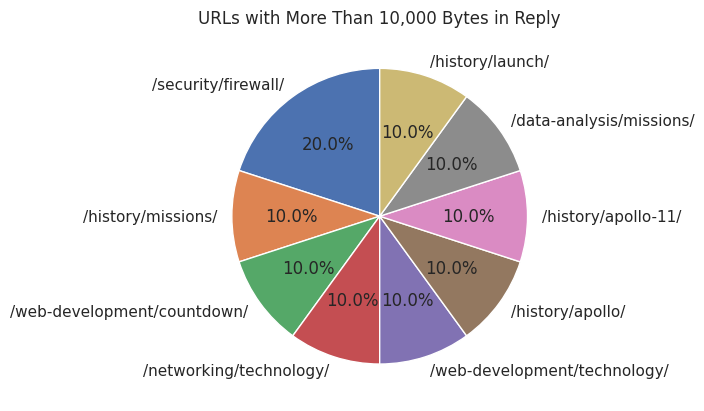

In [ ]:
#Pie chart for URLs with more than 10,0000 bytes in reply
plt.pie(query_5.select("URL").toPandas()["URL"].value_counts(), labels=query_5.select("URL").toPandas()["URL"].value_counts().index, autopct="%1.1f%%", startangle=90)
plt.title("URLs with More Than 10,000 Bytes in Reply")
plt.show()

In [ ]:
#Calculate the cumulative sum of bytes in reply over time
query_6 = spark.sql('SELECT Timestamp, SUM(Bytes_in_reply) OVER (ORDER BY Timestamp) AS cumulative_bytes FROM Weblog LIMIT 20')

query_6.show()

+--------------------+----------------+
|           Timestamp|cumulative_bytes|
+--------------------+----------------+
|01/Apr/2022:00:00:01|           46312|
|01/Apr/2022:00:00:43|           61723|
|01/Apr/2022:00:00:53|          119650|
|01/Apr/2022:00:01:07|          159524|
|01/Apr/2022:00:01:41|          178753|
|01/Apr/2022:00:01:55|          255715|
|01/Apr/2022:00:02:50|          331411|
|01/Apr/2022:00:02:57|          341602|
|01/Apr/2022:00:03:11|          394166|
|01/Apr/2022:00:03:57|          479697|
|01/Apr/2022:00:03:58|          551218|
|01/Apr/2022:00:05:13|          649980|
|01/Apr/2022:00:05:46|          713056|
|01/Apr/2022:00:06:00|          792809|
|01/Apr/2022:00:07:16|          810350|
|01/Apr/2022:00:07:32|          843085|
|01/Apr/2022:00:07:45|          927271|
|01/Apr/2022:00:08:04|          954760|
|01/Apr/2022:00:08:15|          961397|
|01/Apr/2022:00:08:58|         1016654|
+--------------------+----------------+



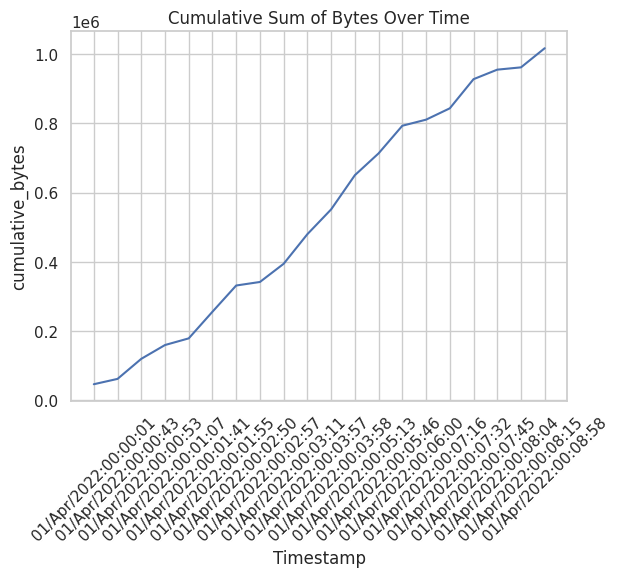

In [ ]:
#Line chart for cumulative sum of bytes over time
sns.lineplot(x="Timestamp", y="cumulative_bytes", data=query_6.toPandas())
plt.title("Cumulative Sum of Bytes Over Time")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#URL Length Distribution:

query_7 = spark.sql('SELECT LENGTH(URL) AS url_length, COUNT(*) AS url_count FROM Weblog GROUP BY url_length LIMIT 15')
query_7.show()

+----------+---------+
|url_length|url_count|
+----------+---------+
|        31|    99727|
|        28|   150185|
|        27|   199457|
|        26|   200548|
|        22|   200233|
|        13|    24919|
|        16|   100110|
|        20|   175264|
|        40|    49748|
|        48|    49639|
|        19|   274915|
|        41|    50069|
|        15|   100245|
|        43|    25124|
|        17|   174405|
+----------+---------+



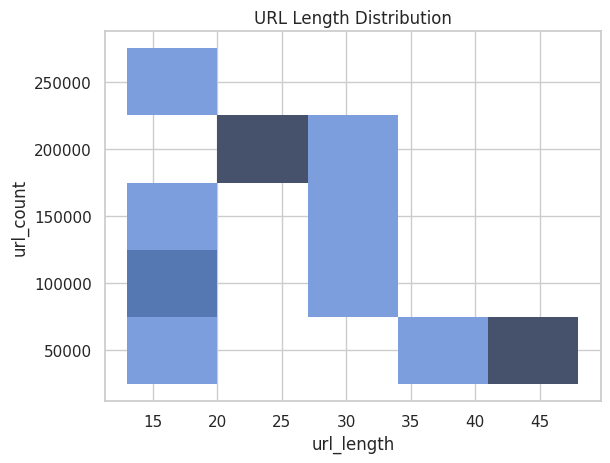

In [ ]:
#Histogram
sns.histplot(x="url_length", y="url_count", data=query_7.toPandas())
plt.title("URL Length Distribution")
plt.show()

In [ ]:
#Request Count Over Time:

query_8 = spark.sql('SELECT Timestamp, COUNT(*) AS request_count FROM Weblog GROUP BY Timestamp ORDER BY request_count DESC LIMIT 10')
query_8.show()

+--------------------+-------------+
|           Timestamp|request_count|
+--------------------+-------------+
|27/Apr/2023:16:30:03|            4|
|14/Feb/2023:17:48:43|            4|
|20/Jul/2023:17:15:09|            4|
|02/Oct/2023:21:52:25|            4|
|02/Oct/2022:07:51:49|            4|
|15/Apr/2023:21:54:16|            4|
|24/Aug/2022:15:55:48|            4|
|03/Mar/2023:06:31:23|            4|
|25/Oct/2022:09:12:33|            4|
|26/Oct/2022:21:59:54|            4|
+--------------------+-------------+



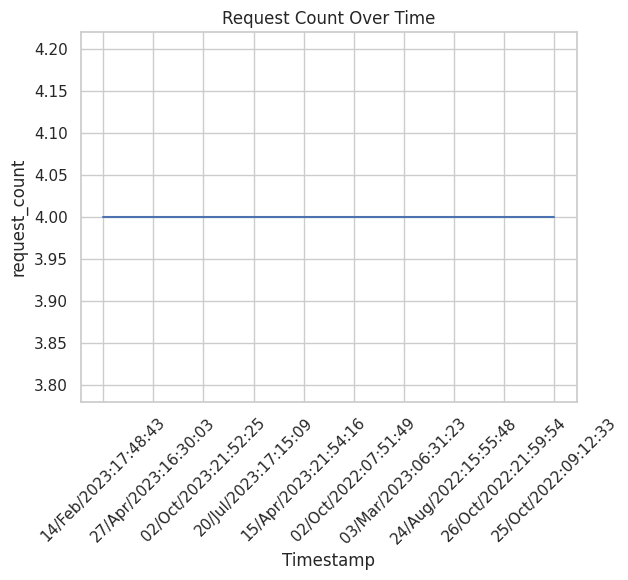

In [ ]:
#Line chart
sns.lineplot(x="Timestamp", y="request_count", data=query_8.toPandas())
plt.title("Request Count Over Time")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Top 5 Messages with Highest Request Count:

query_9 = spark.sql('SELECT Message, COUNT(*) AS request_count FROM Weblog GROUP BY Message ORDER BY request_count DESC LIMIT 5')
query_9.show()


+--------------------+-------------+
|             Message|request_count|
+--------------------+-------------+
|Update: Routine s...|       334156|
|Developer Note: D...|       333769|
|Potential issue d...|       333758|
|FYI: System opera...|       333579|
|Debug: Detailed s...|       333389|
+--------------------+-------------+



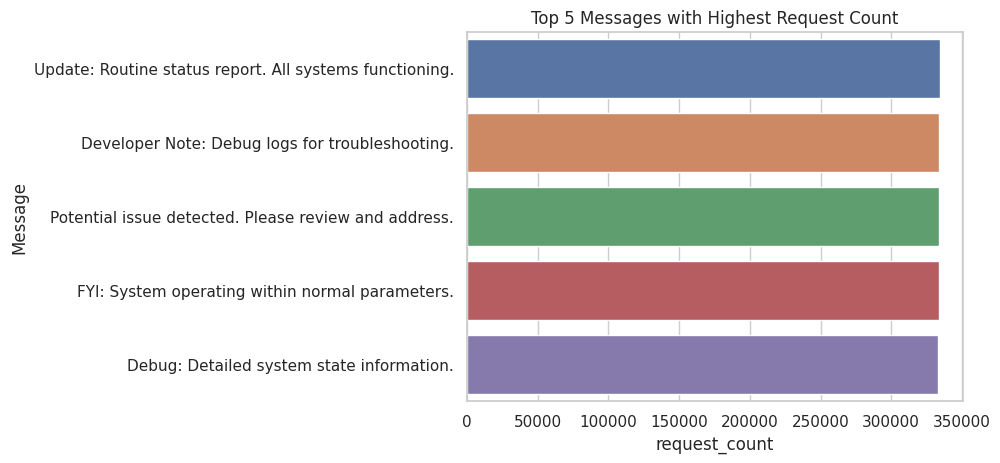

In [ ]:
#Bar chart
sns.barplot(x="request_count", y="Message", data=query_9.toPandas(), orient="h")
plt.title("Top 5 Messages with Highest Request Count")
plt.show()

In [ ]:
#Calculate the percentage of requests with cautionary messages for each HTTP method
query_10 = spark.sql("""
    SELECT HTTP_method,
           COUNT(*) AS total_requests,
           (SUM(CASE WHEN Message LIKE 'Caution:%' THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS caution_percentage
    FROM Weblog
    GROUP BY HTTP_method
    ORDER BY caution_percentage DESC
""")
query_10.show()

+-----------+--------------+------------------+
|HTTP_method|total_requests|caution_percentage|
+-----------+--------------+------------------+
|        PUT|        998452|11.112101533173352|
|        GET|       1001043|11.105017466782147|
|       POST|       1000505|11.073407928995858|
+-----------+--------------+------------------+



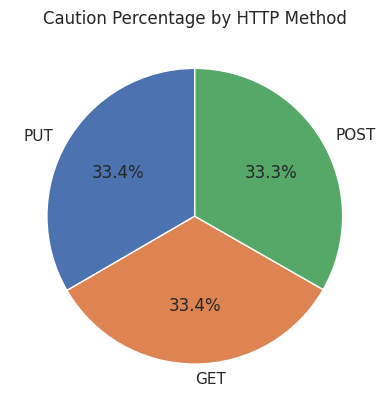

In [ ]:
#Pie chart for caution percentage by HTTP method
plt.pie(query_10.select("caution_percentage").toPandas()["caution_percentage"],
        labels=query_10.select("HTTP_method").toPandas()["HTTP_method"],
        autopct="%1.1f%%", startangle=90)
plt.title("Caution Percentage by HTTP Method")
plt.show()

**RDD QUERIES**

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [ ]:
sc = spark.sparkContext
# Read the log data into an RDD
log_rdd = sc.textFile("/content/drive/MyDrive/web.log")
log_rdd.take(5)

['88.211.105.115 - - [04/Mar/2022:14:17:48] "POST /history/missions/ HTTP/2.0" 414 12456 Caution: System may require attention. Check logs for details.',
 '144.6.49.142 - - [02/Sep/2022:15:16:00] "POST /security/firewall/ HTTPS/1.0" 203 97126 Warning: Unusual behavior detected. Investigate further.',
 '231.70.64.145 - - [19/Jul/2022:01:31:31] "PUT /web-development/countdown/ HTTP/1.0" 201 33093 Informational message. No action required.',
 '219.42.234.172 - - [08/Feb/2022:11:34:57] "POST /networking/technology/ HTTP/1.0" 415 68827 Debug: Detailed system state information.',
 '183.173.185.94 - - [29/Aug/2023:03:07:11] "GET /security/firewall/ HTTP/2.0" 205 30374 Warning: Unusual behavior detected. Investigate further.']

In [ ]:
pip install matplotlib

In [ ]:
%%time
#query 1: Extract IP addresses with "Debug" messages and limit the output to count of 10
import matplotlib.pyplot as plt
# Transformation: Filter logs with "Debug" messages and extract IP addresses
debug_logs = log_rdd.filter(lambda line: "Debug" in line).map(lambda line: line.split(' ')[0])

# Action: Count the occurrences of each IP address
ip_counts = debug_logs.countByValue()

# Extract top 10 IP addresses and their counts
top_ips = list(ip_counts.items())[:10]
print("Top 10 IP Addresses with Debug  Messages:\n")
print(top_ips)



Top 10 IP Addresses with Debug  Messages:

[('219.42.234.172', 1), ('110.98.7.240', 1), ('123.31.25.147', 1), ('220.182.78.75', 1), ('206.186.128.82', 1), ('143.238.50.180', 1), ('246.167.148.159', 1), ('144.143.171.58', 1), ('219.102.10.10', 1), ('8.15.149.55', 1)]


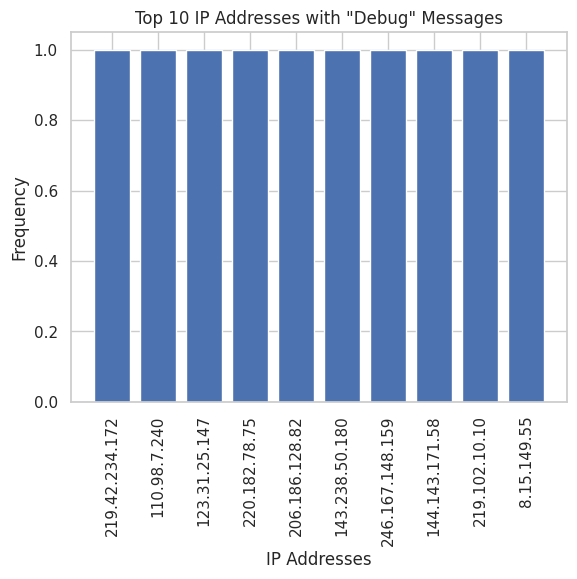

In [ ]:
# Visualization for query 1: Create a bar chart
ip_addresses, counts = zip(*top_ips)

plt.bar(ip_addresses, counts)
plt.xlabel('IP Addresses')
plt.ylabel('Frequency')
plt.title('Top 10 IP Addresses with "Debug" Messages')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
#query 2: Calculate the total size of responses for each URL, considering only successful responses (status code 200):
"""
successful_logs = log_rdd.filter(lambda line: "HTTP/1.0\" 200" in line or "HTTP/2.0\" 200" in line)
url_response_sizes = successful_logs.map(lambda line: (line.split(' ')[6], int(line.split(' ')[-1]) if line.split(' ')[-1].isdigit() else 0))

# Action: Calculate the total size of responses for each URL
total_size_per_url = url_response_sizes.reduceByKey(lambda a, b: a + b)

# Action: Show the results
for (url, total_size) in total_size_per_url.collect():
    print(f"URL: {url}, Total Response Size: {total_size} bytes")
"""


'\nsuccessful_logs = log_rdd.filter(lambda line: "HTTP/1.0" 200" in line or "HTTP/2.0" 200" in line)\nurl_response_sizes = successful_logs.map(lambda line: (line.split(\' \')[6], int(line.split(\' \')[-1]) if line.split(\' \')[-1].isdigit() else 0))\n\n# Action: Calculate the total size of responses for each URL\ntotal_size_per_url = url_response_sizes.reduceByKey(lambda a, b: a + b)\n\n# Action: Show the results\nfor (url, total_size) in total_size_per_url.collect():\n    print(f"URL: {url}, Total Response Size: {total_size} bytes")\n'

In [ ]:
pip install networkx

total:
PythonRDD[215] at RDD at PythonRDD.scala:53


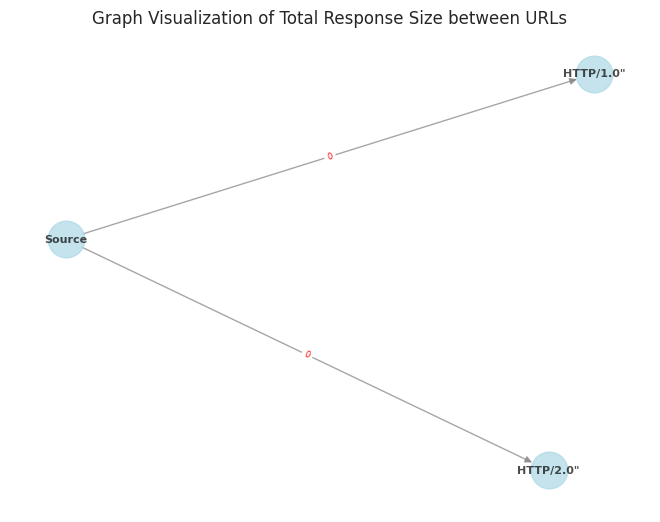

In [ ]:
#query 2: Calculate the total size of responses for each URL, considering only successful responses (status code 200):
import networkx as nx
successful_logs = log_rdd.filter(lambda line: "HTTP/1.0\" 200" in line or "HTTP/2.0\" 200" in line)
url_response_sizes = successful_logs.map(lambda line: (line.split(' ')[6], int(line.split(' ')[-1]) if line.split(' ')[-1].isdigit() else 0))

# Action: Calculate the total size of responses for each URL
total_size_per_url = url_response_sizes.reduceByKey(lambda a, b: a + b)
print("total:")
print(total_size_per_url)

# Collect the results for visualization
results = total_size_per_url.collect()

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for url, size in results:
    G.add_node(url, size=size)
    G.add_edge("Source", url, weight=size)

# Visualization: Create a directed graph plot
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, font_size=8, font_color='black', font_weight='bold', node_color='lightblue', edge_color='gray', width=1, alpha=0.7, arrows=True)

# Display edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=6)

plt.title('Graph Visualization of Total Response Size between URLs')
plt.show()


top 5 IP's are:
[('78.231.43.75', 2), ('1.21.213.107', 2), ('81.113.19.213', 2), ('56.156.122.197', 2), ('248.214.152.183', 2)]


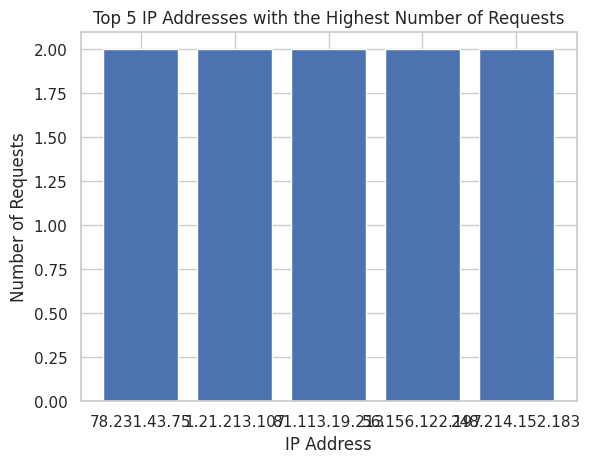

In [ ]:
#query 3: Find the top 5 IP addresses with the highest number of requests
ip_addresses = log_rdd.map(lambda line: line.split(' ')[0])

# Action: Count the occurrences of each IP address
ip_counts = ip_addresses.countByValue()

# Find the top 5 IP addresses with the highest number of requests
top_5_ips = sorted(ip_counts.items(), key=lambda x: x[1], reverse=True)[:5]
print("top 5 IP's are:")
print(top_5_ips)

# Visualization: Create a bar chart for the top 5 IP addresses
ips, counts = zip(*top_5_ips)

plt.bar(ips, counts)
plt.xlabel('IP Address')
plt.ylabel('Number of Requests')
plt.title('Top 5 IP Addresses with the Highest Number of Requests')
plt.show()

164.12.8.113 - - [22/May/2023:09:48:25] "GET /web-development/technology/ HTTP/1.0" 200 14633 Informational message. No action required.
220.182.78.75 - - [22/Dec/2022:12:55:00] "GET /history/launch/ HTTP/2.0" 200 84446 Debugging information. For developer reference only.
101.138.193.157 - - [20/Jun/2023:16:01:03] "PUT /security/deep-learning/ HTTP/2.0" 200 2228 Informational message. No action required.
148.57.229.186 - - [27/Sep/2022:12:41:36] "PUT /machine-learning/apollo-11/ HTTP/2.0" 200 5918 Developer Note: Debug logs for troubleshooting.
119.193.113.218 - - [21/Jul/2023:20:28:59] "POST /web-development/aws-certification/ HTTP/2.0" 200 23158 Debugging information. For developer reference only.
194.224.206.254 - - [29/Dec/2022:00:41:07] "POST /history/deep-learning/ HTTP/1.0" 200 35754 Debug: Detailed system state information.
102.87.72.243 - - [06/Jul/2022:02:29:26] "PUT /machine-learning/data/ HTTP/2.0" 200 66877 Developer Note: Debug logs for troubleshooting.
66.106.18.183 - - 

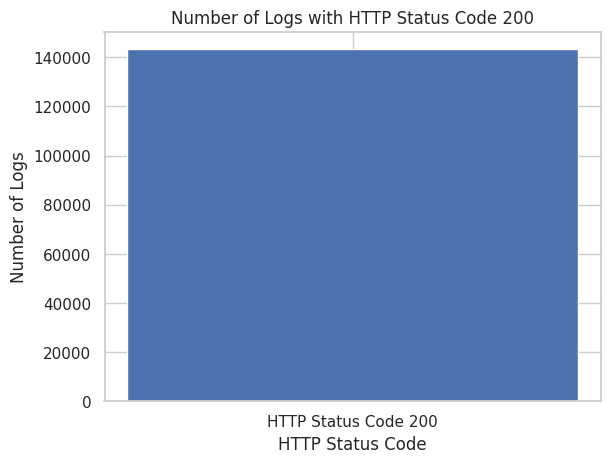

In [ ]:
#query 4: Count the number of logs with HTTP status code 200
logs_status_200 = log_rdd.filter(lambda line: "HTTP/1.0\" 200" in line or "HTTP/2.0\" 200" in line)

# Action: Count the number of logs with status code 200
status_200_count = logs_status_200.count()

# Display 10 logs with status code 200
sample_logs_status_200 = logs_status_200.take(10)
for log in sample_logs_status_200:
    print(log)

# Visualization: Create a bar chart for the count of logs with status code 200
labels = ['HTTP Status Code 200']
counts = [status_200_count]

plt.bar(labels, counts)
plt.xlabel('HTTP Status Code')
plt.ylabel('Number of Logs')
plt.title('Number of Logs with HTTP Status Code 200')
plt.show()

PythonRDD[223] at RDD at PythonRDD.scala:53
[('reference', 0.0), ('and', 0.0), ('systems', 0.0), ('normal', 0.0), ('action', 0.0), ('Investigate', 0.0), ('for', 0.0), ('state', 0.0)]


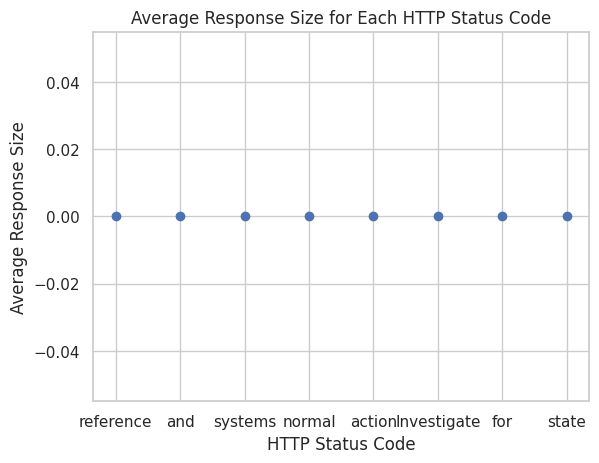

In [ ]:
#query 5: Calculate the average response size for each HTTP status code
status_code_response_size = log_rdd.map(lambda line: (line.split(' ')[-2], int(line.split(' ')[-1]) if line.split(' ')[-1].isdigit() else 0))

# Action: Calculate the total response size and count for each HTTP status code
total_size_and_count_per_status_code = status_code_response_size.aggregateByKey((0, 0), lambda x, y: (x[0] + y, x[1] + 1), lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Action: Calculate the average response size for each HTTP status code
average_response_size_per_status_code = total_size_and_count_per_status_code.mapValues(lambda x: x[0] / x[1] if x[1] != 0 else 0)
print(average_response_size_per_status_code)

# Collect the results for visualization
results_per_status_code = average_response_size_per_status_code.collect()
print(results_per_status_code)
# Visualization: Create a scatter plot for average response size per HTTP status code
status_codes, avg_response_sizes = zip(*results_per_status_code)

plt.scatter(status_codes, avg_response_sizes)
plt.xlabel('HTTP Status Code')
plt.ylabel('Average Response Size')
plt.title('Average Response Size for Each HTTP Status Code')
plt.show()


Number of Unique URLs: 3


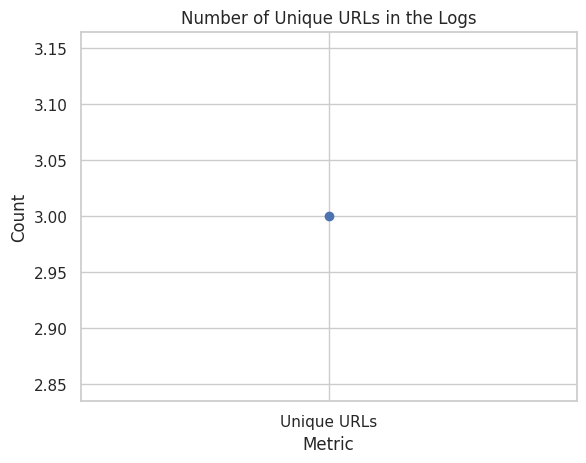

In [ ]:
#query 6 : Count the number of unique URLs in the logs
urls = log_rdd.map(lambda line: line.split(' ')[6])

# Action: Count the number of unique URLs
unique_url_count = urls.distinct().count()

# Display the number of unique URLs
print(f"Number of Unique URLs: {unique_url_count}")

# Visualization: Create a bar chart for the number of unique URLs
labels1 = ['Unique URLs']
counts1 = [unique_url_count]

plt.scatter(labels1, counts1)
plt.xlabel('Metric')
plt.ylabel('Count')
plt.title('Number of Unique URLs in the Logs')
plt.show()

In [ ]:
#query 7: Identify the most common HTTP methods used in the logs
#Extract HTTP methods
http_methods = log_rdd.map(lambda line: line.split(' ')[-2])

# Action: Count the occurrences of each HTTP method
http_method_counts = http_methods.countByValue()

# Display the counts of each HTTP method
for method, count in http_method_counts.items():
    print(f"{method}: {count}")

for: 666674
Investigate: 333165
action: 333091
state: 333389
reference: 332188
normal: 333579
and: 333758
systems: 334156


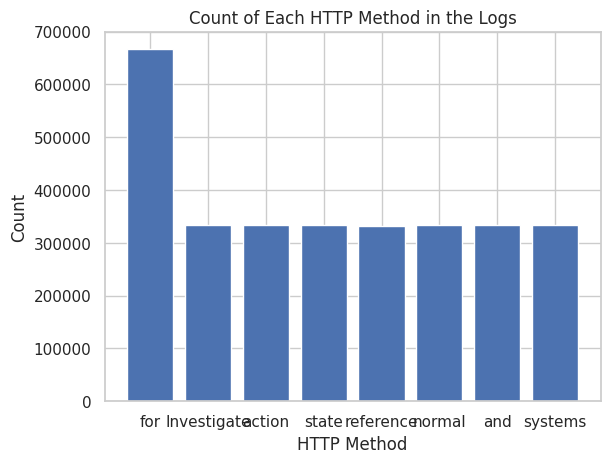

In [ ]:
#Create a bar chart for the counts of each HTTP method
methods, counts = zip(*http_method_counts.items())

plt.bar(methods, counts)
plt.xlabel('HTTP Method')
plt.ylabel('Count')
plt.title('Count of Each HTTP Method in the Logs')
plt.show()

In [ ]:
#query 8: Find the timestamp with the highest number of requests
#Extract timestamps
timestamps = log_rdd.map(lambda line: line.split('[')[1].split(']')[0])

# Action: Count the occurrences of each timestamp
timestamp_counts = timestamps.countByValue()

# Find the top 10 timestamps with the highest number of requests
top_timestamps = dict(sorted(timestamp_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Display the counts of each top timestamp
for timestamp, count in top_timestamps.items():
    print(f"{timestamp}: {count}")

14/Feb/2023:17:48:43: 4
02/Oct/2022:07:51:49: 4
03/Aug/2022:07:41:05: 4
13/May/2023:21:43:08: 4
19/Aug/2023:13:55:32: 4
24/Jul/2022:14:54:45: 4
20/Jul/2023:17:15:09: 4
28/Jan/2023:03:46:44: 4
27/Apr/2023:16:30:03: 4
15/Apr/2023:21:54:16: 4


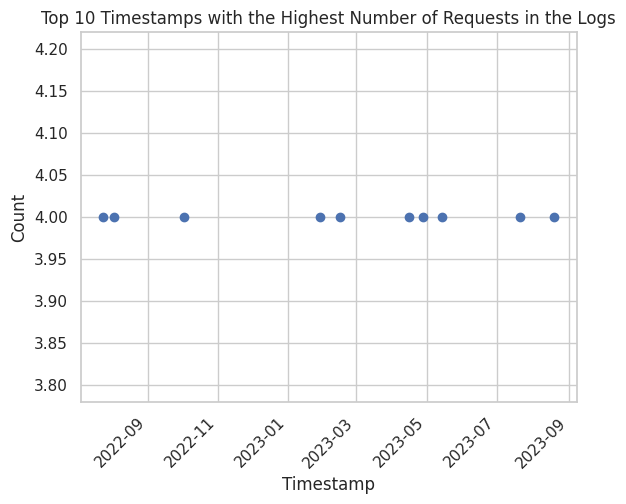

In [ ]:
#Create a bar chart for the counts of each top timestamp
from datetime import datetime
timestamps, counts = zip(*top_timestamps.items())
timestamps = [datetime.strptime(ts, "%d/%b/%Y:%H:%M:%S") for ts in timestamps]

plt.scatter(timestamps, counts)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Top 10 Timestamps with the Highest Number of Requests in the Logs')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#query 9: Identify the top 5 requested URIs along with the corresponding count

#Extract URLs
urls = log_rdd.map(lambda line: line.split(' ')[6])

# Action: Count the occurrences of each URL
url_counts = urls.countByValue()

# Find the top 5 requested URLs
top_urls = dict(sorted(url_counts.items(), key=lambda x: x[1], reverse=True)[:5])

# Display the counts of each top URL
for url, count in top_urls.items():
    print(f"URL: {url}, Count: {count}")


URL: HTTP/2.0", Count: 1000568
URL: HTTP/1.0", Count: 1000084
URL: HTTPS/1.0", Count: 999348


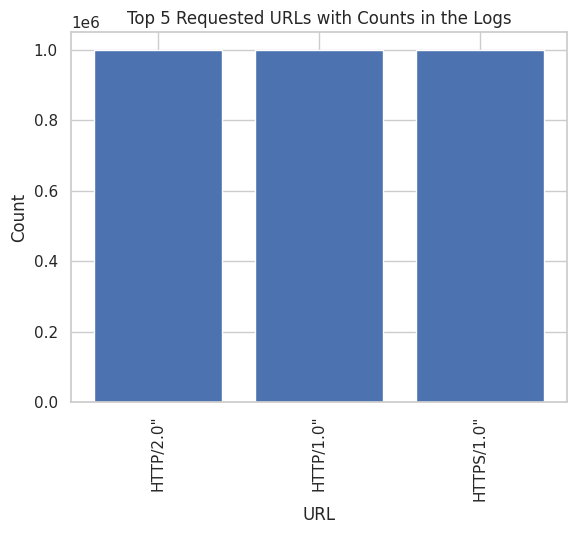

In [ ]:
#Create a bar chart for the counts of each top URL
urls, counts = zip(*top_urls.items())

plt.bar(urls, counts)
plt.xlabel('URL')
plt.ylabel('Count')
plt.title('Top 5 Requested URLs with Counts in the Logs')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
#query 10: Extract IP addresses with "Warning" messages
#Filter logs with "Warning" messages and extract IP addresses
warning_logs = log_rdd.filter(lambda line: "Warning" in line).map(lambda line: line.split(' ')[0])

# Action: Limit the output to 12
limited_warning_ips = warning_logs.take(12)
print("IP addresses with 'Warning' messages (limited to 12):")
for ip_address in limited_warning_ips:
    print(ip_address)


IP addresses with 'Warning' messages (limited to 12):
144.6.49.142
183.173.185.94
12.33.251.59
103.105.160.60
155.22.118.135
26.22.112.17
73.197.144.95
17.56.217.163
155.24.8.49
41.251.132.194
24.72.7.2
230.89.159.50


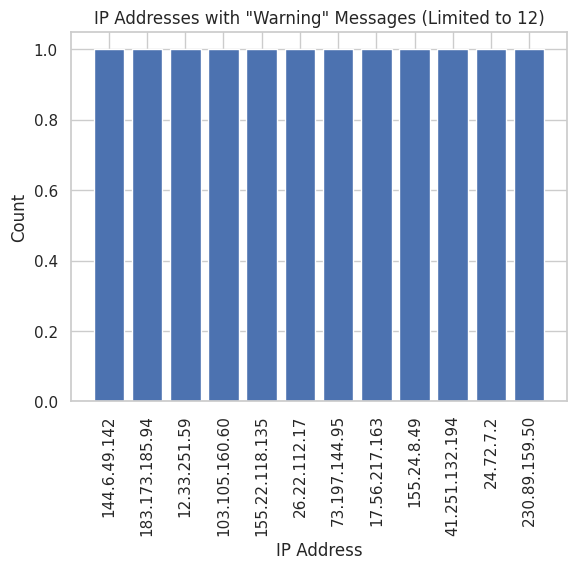

In [ ]:
# Create a bar chart for IP addresses with "Warning" messages
plt.bar(range(len(limited_warning_ips)), [1] * len(limited_warning_ips), tick_label=limited_warning_ips)
plt.xlabel('IP Address')
plt.ylabel('Count')
plt.title('IP Addresses with "Warning" Messages (Limited to 12)')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
#query 11: Extract URLs with "POST" requests with visualization and limit to 20
#Filter logs with "POST" requests and extract URLs
post_logs = log_rdd.filter(lambda line: "POST" in line)
post_urls = post_logs.map(lambda line: line.split(' ')[6])

# Action: Limit the output to 20
limited_post_urls = post_urls.take(20)
print("URLs with 'POST' requests (limited to 20):")
for url in limited_post_urls:
    print(url)

URLs with 'POST' requests (limited to 20):
HTTP/2.0"
HTTPS/1.0"
HTTP/1.0"
HTTPS/1.0"
HTTPS/1.0"
HTTP/2.0"
HTTPS/1.0"
HTTP/2.0"
HTTP/2.0"
HTTP/2.0"
HTTP/2.0"
HTTP/2.0"
HTTP/1.0"
HTTPS/1.0"
HTTPS/1.0"
HTTP/1.0"
HTTP/2.0"
HTTP/1.0"
HTTPS/1.0"
HTTP/2.0"


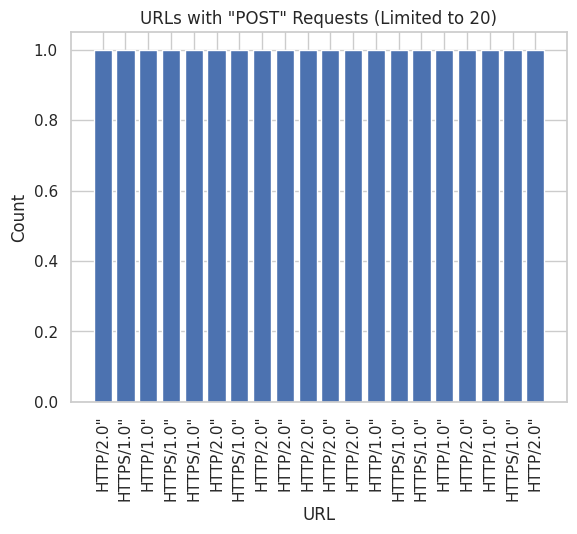

In [ ]:
#Create a bar chart for URLs with "POST" requests (limited to 20)
plt.bar(range(len(limited_post_urls)), [1] * len(limited_post_urls), tick_label=limited_post_urls)
plt.xlabel('URL')
plt.ylabel('Count')
plt.title('URLs with "POST" Requests (Limited to 20)')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
#query 12: Extract dates and count the number of requests for each date
date_requests_count = log_rdd.map(lambda line: (line.split('[')[1].split(':')[0], 1)).reduceByKey(lambda a, b: a + b)

# Transformation: Sort the dates by the number of requests in descending order
sorted_dates = date_requests_count.sortBy(lambda x: x[1], ascending=False)

# Action: Take the top 10 dates with the highest number of requests
top_10_dates = sorted_dates.take(10)
print(top_10_dates)


[('09/Sep/2022', 4604), ('11/Oct/2022', 4601), ('09/Jul/2022', 4592), ('06/May/2023', 4592), ('23/Jan/2022', 4581), ('28/May/2022', 4572), ('26/Oct/2022', 4569), ('12/Dec/2022', 4568), ('08/May/2023', 4554), ('18/May/2022', 4545)]


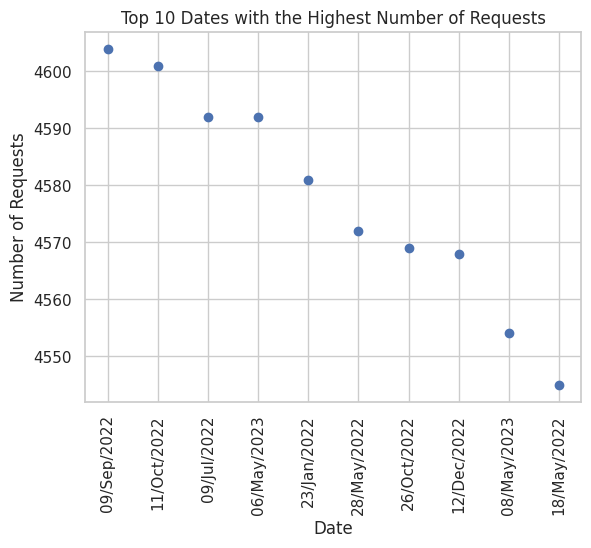

In [ ]:
dates, counts = zip(*top_10_dates)
plt.scatter(dates, counts)
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.title('Top 10 Dates with the Highest Number of Requests')
plt.xticks(rotation='vertical')
plt.show()